# feature extraction for logistic ADNI models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading ADNI flair mask t1 dataset

In [3]:
# ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

In [4]:
# IDs = ADNI_ds.getIDs()

In [5]:
# len(IDs)

### Loading ADNI predictions

In [6]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [8]:
# model_name = "SSN_Ens_Mean"
model_name = "punet"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [01:16<00:00,  3.80it/s]


In [9]:
# model_name_for_pred = "SSN_Ens_Mean"
model_name = "punet"

output_maps_for_pred = output_maps_for_umaps
key_order_for_pred = key_order

In [10]:
key_order

['ent', 'pred', 'seg']

In [11]:
ID = list(output_maps_for_umaps.keys())[2]

In [12]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

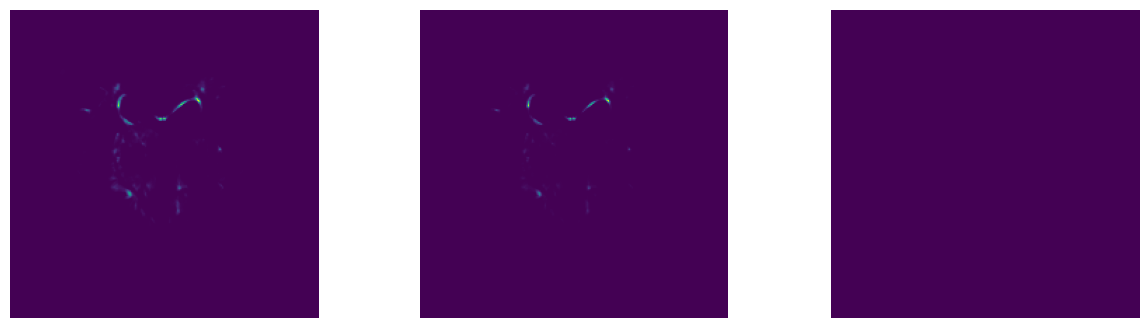

In [13]:
ent, pred, seg = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [14]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
# var_voxels = var[var > t/10]

<Axes: ylabel='Density'>

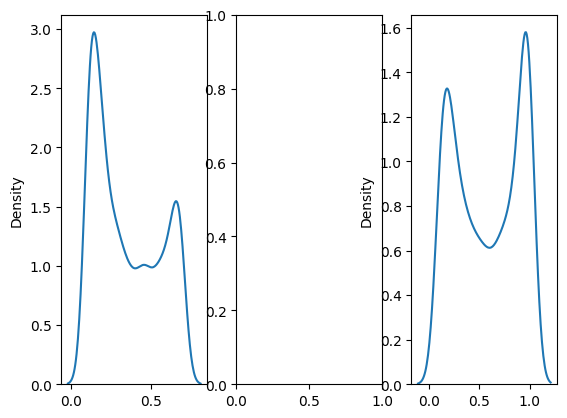

In [15]:
plt.subplot(1,3,1)
sns.kdeplot(ent_voxels)
plt.subplot(1,3,2)
# sns.kdeplot(var_voxels)
plt.subplot(1,3,3)
sns.kdeplot(pred_voxels)

In [16]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [17]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [18]:
histogram_distribution(ent_voxels, 20)

tensor([0.1604, 0.1136, 0.0863, 0.0765, 0.0441, 0.0508, 0.0474, 0.0343, 0.0349,
        0.0318, 0.0266, 0.0376, 0.0370, 0.0257, 0.0331, 0.0334, 0.0383, 0.0367,
        0.0514, 0.0000])

In [19]:
# counts, counts.sum()

<Axes: ylabel='Count'>

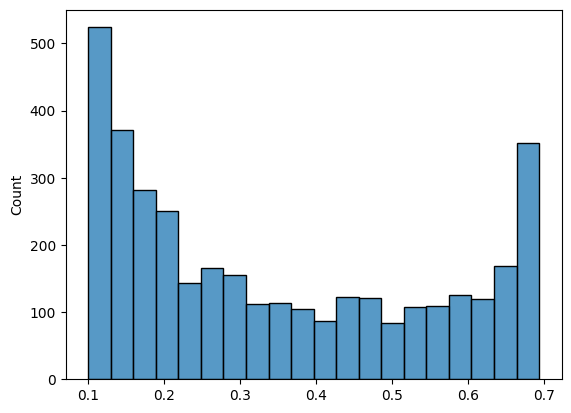

In [20]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [21]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [22]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [23]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((220, 220))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [24]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [25]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([58, 220, 220])

In [26]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:25<00:00, 11.55it/s]


In [27]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([58, 220, 220]), tensor(33))

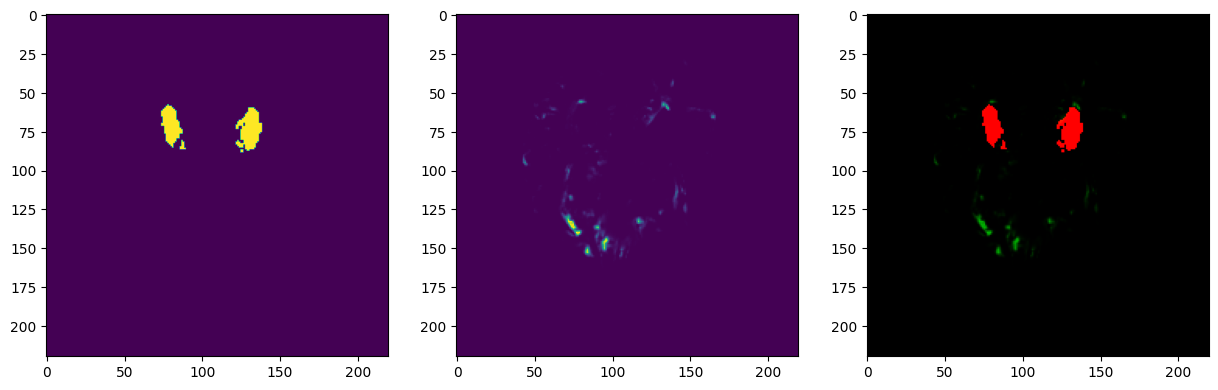

In [28]:
islice = 26
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[0].shape[1:], 3)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [29]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [30]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [31]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [32]:
import cc3d

In [33]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [34]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [35]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [36]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [37]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [38]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [39]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [40]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [41]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [42]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [43]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [44]:
# joint_counts.shape

In [45]:
# plt.imshow(joint_counts); plt.colorbar()

In [46]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [47]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [48]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [49]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [50]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [51]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [52]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [53]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            # elif input_type == "var":
            #     umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
            #     ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
            #     maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
    # break
        

  0%|                                                                                                                                                                 | 0/290 [00:00<?, ?it/s]

ADNI_002_S_0729_20110816


/tmp/ipykernel_344931/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_344931/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


144 129
123 94
152 79
303 104
440 133
564 153
83 57
62 28
57 19
55 10
55 0


  0%|▌                                                                                                                                                        | 1/290 [00:08<40:01,  8.31s/it]

47 0
ADNI_002_S_1155_20111222
207 193
134 115
115 88
124 71
127 59
132 51
105 84
64 40
53 28
40 13


  1%|█                                                                                                                                                        | 2/290 [00:10<23:00,  4.79s/it]

34 0
28 0
ADNI_002_S_1261_20110314
135 121
91 71
69 46
75 41
83 43
94 32
68 44
57 31
45 16


  1%|█▌                                                                                                                                                       | 3/290 [00:12<15:47,  3.30s/it]

42 13
32 0
28 0
ADNI_002_S_1280_20110504
142 120
110 81
166 96
281 105
364 126
462 142
91 64
67 34
56 20
46 7


  1%|██                                                                                                                                                       | 4/290 [00:15<15:18,  3.21s/it]

49 0
50 0
ADNI_002_S_2010_20101022
140 126
85 70
66 46
54 32
61 31
65 29
51 35
31 14


  2%|██▋                                                                                                                                                      | 5/290 [00:17<12:56,  2.73s/it]

26 9
25 5
20 0
17 0
ADNI_002_S_4213_20111205
147 122
103 76
106 68
101 51
103 47
126 55
92 63
74 43
53 21
47 13


  2%|███▏                                                                                                                                                     | 6/290 [00:19<12:09,  2.57s/it]

37 0
34 0
ADNI_002_S_4225_20111226
251 219
165 128
133 89
128 70
138 65
169 73
121 79
90 44
85 33
79 16


  2%|███▋                                                                                                                                                     | 7/290 [00:21<12:00,  2.55s/it]

72 0
65 0
ADNI_002_S_4229_20111221
296 251
259 197
235 159
269 136
327 142
394 159
217 146
176 90
161 61
152 35
134 0


  3%|████▏                                                                                                                                                    | 8/290 [00:26<15:24,  3.28s/it]

122 0
ADNI_002_S_4237_20110926
342 297
282 223
277 190
328 174
399 182
466 181
245 173
207 116
205 89
173 41
177 0


  3%|████▋                                                                                                                                                    | 9/290 [00:33<20:02,  4.28s/it]

158 0
ADNI_002_S_4262_20111005
280 235
246 188
283 189
403 180
538 212
729 253
222 152
188 94
161 56
144 24
139 0


  3%|█████▏                                                                                                                                                  | 10/290 [00:39<22:10,  4.75s/it]

141 0
ADNI_002_S_4270_20111011
148 134
114 95
105 75
157 81
187 77
248 89
84 62
68 41
51 21
46 9


  4%|█████▊                                                                                                                                                  | 11/290 [00:41<18:26,  3.97s/it]

44 0
41 0
ADNI_002_S_4447_20120814
168 140
99 70
109 62
162 70
198 79
236 85
76 44
71 32
66 22


  4%|██████▎                                                                                                                                                 | 12/290 [00:43<16:00,  3.46s/it]

61 13
55 0
47 0
ADNI_002_S_4473_20120823
385 337
301 243
256 181
238 142
244 124
273 126
225 161
170 94
148 58
139 37
122 0


  4%|██████▊                                                                                                                                                 | 13/290 [00:47<16:55,  3.67s/it]

100 0
ADNI_002_S_4521_20120904
228 209
170 147
134 101
133 78
140 67
169 66
111 86
77 48
59 22
50 9
43 0


  5%|███████▎                                                                                                                                                | 14/290 [00:50<15:58,  3.47s/it]

42 0
ADNI_002_S_4654_20121023
217 195
139 113
121 85
125 60
173 61
220 74
93 63
66 34
61 27


  5%|███████▊                                                                                                                                                | 15/290 [00:53<15:06,  3.30s/it]

56 15
45 0
37 0
ADNI_006_S_4150_20111107
151 136
110 91
91 70
112 61
128 62
151 59
78 62
53 36
41 23
28 8
23 0


  6%|████████▍                                                                                                                                               | 16/290 [00:55<12:54,  2.83s/it]

24 0
ADNI_006_S_4153_20111104
142 135
108 96
84 66
116 69
159 77
226 87
72 57
71 50
53 27
41 14


  6%|████████▉                                                                                                                                               | 17/290 [00:57<11:45,  2.59s/it]

36 0
33 0
ADNI_006_S_4192_20111215
308 263
249 189
226 147
252 131
275 117
316 122
200 132
154 75
134 45
127 27
118 0


  6%|█████████▍                                                                                                                                              | 18/290 [01:01<13:34,  2.99s/it]

98 0
ADNI_006_S_4357_20111128
151 143
108 88
92 61
106 55
125 55
145 47
72 53
59 31
53 20


  7%|█████████▉                                                                                                                                              | 19/290 [01:03<11:55,  2.64s/it]

55 16
44 0
37 0
ADNI_006_S_4363_20111116
119 110
81 66
73 55
71 40
86 44
114 54
68 51
49 31
46 24


  7%|██████████▍                                                                                                                                             | 20/290 [01:04<10:18,  2.29s/it]

38 11
39 0
39 0
ADNI_006_S_4485_20120824
249 204
227 171
278 152
442 149
542 170
665 180
153 103
113 56
95 26
84 12


  7%|███████████                                                                                                                                             | 21/290 [01:09<13:37,  3.04s/it]

79 0
77 0
ADNI_006_S_4679_20120601
208 180
142 106
166 98
217 86
259 91
287 84
114 76
80 35
72 26
65 14
61 0


  8%|███████████▌                                                                                                                                            | 22/290 [01:12<13:17,  2.98s/it]

53 0
ADNI_006_S_4713_20121128
187 174
119 100
102 77
122 63
153 57
199 60
80 61
51 30
41 16
40 12


  8%|████████████                                                                                                                                            | 23/290 [01:14<11:58,  2.69s/it]

37 0
29 0
ADNI_006_S_4960_20121009
251 212
219 171
197 135
206 107
221 102
269 103
175 115
141 69
128 45
128 28
121 0


  8%|████████████▌                                                                                                                                           | 24/290 [01:18<14:35,  3.29s/it]

118 0
ADNI_009_S_2208_20101201
122 105
98 73
86 50
101 51
121 48
155 50
66 45
50 27
46 19
40 9


  9%|█████████████                                                                                                                                           | 25/290 [01:20<12:47,  2.90s/it]

36 0
35 0
ADNI_009_S_4324_20111101
128 117
92 77
103 62
148 61
169 55
205 58
66 51
51 32
47 23
38 9


  9%|█████████████▋                                                                                                                                          | 26/290 [01:22<11:26,  2.60s/it]

36 0
32 0
ADNI_009_S_4359_20111205
122 110
87 71
88 48
150 58
183 62
236 74
57 42
44 27
36 17
38 11
32 0


  9%|██████████████▏                                                                                                                                         | 27/290 [01:24<10:28,  2.39s/it]

29 0
ADNI_009_S_4388_20111213
112 104
98 81
76 46
108 44
146 48
171 42
50 38
34 21


 10%|██████████████▋                                                                                                                                         | 28/290 [01:26<09:23,  2.15s/it]

24 10
25 10
19 0
19 0
ADNI_009_S_4543_20120912
101 85
73 52
70 34
128 37
167 45
206 50
53 31
42 18
40 13
36 7
31 0


 10%|███████████████▏                                                                                                                                        | 29/290 [01:27<08:47,  2.02s/it]

36 0
ADNI_009_S_4612_20121011
190 142
191 127
217 115
306 110
392 127
507 149
167 96
144 59
131 38
128 21


 10%|███████████████▋                                                                                                                                        | 30/290 [01:32<11:35,  2.67s/it]

127 0
121 0
ADNI_009_S_4741_20121015
230 199
165 128
143 102
201 112
228 110
270 107
137 101
130 79
116 58
96 27
81 0


 11%|████████████████▏                                                                                                                                       | 31/290 [01:35<12:02,  2.79s/it]

69 0
ADNI_010_S_4345_20120920
176 155
145 122
143 101
185 89
229 97
275 111
123 96
81 51
69 34
54 15
45 0


 11%|████████████████▊                                                                                                                                       | 32/290 [01:37<11:44,  2.73s/it]

32 0
ADNI_011_S_0021_20101008
185 168
126 103
94 68
94 54
103 48
124 50
90 64
67 39
58 27
47 14


 11%|█████████████████▎                                                                                                                                      | 33/290 [01:39<10:36,  2.48s/it]

39 0
40 0
ADNI_011_S_0023_20121227
153 136
99 77
83 53
105 49
138 54
163 52
68 45
53 22
45 13
45 8


 12%|█████████████████▊                                                                                                                                      | 34/290 [01:41<09:41,  2.27s/it]

43 0
43 0
ADNI_011_S_2274_20110818
235 222
156 142
128 101
171 99
195 94
242 90
105 87
92 67
68 38


 12%|██████████████████▎                                                                                                                                     | 35/290 [01:44<10:03,  2.37s/it]

57 21
48 0
37 0
ADNI_011_S_4075_20111214
143 135
86 78
84 70
120 69
143 64
174 61
69 61
48 37
39 24
35 13


 12%|██████████████████▊                                                                                                                                     | 36/290 [01:45<09:15,  2.19s/it]

30 0
34 0
ADNI_011_S_4105_20111005
151 140
113 94
99 69
127 66
157 72
169 70
82 61
63 42
45 23
40 12


 13%|███████████████████▍                                                                                                                                    | 37/290 [01:47<08:52,  2.11s/it]

33 0
32 0
ADNI_011_S_4120_20111010
165 154
108 92
90 55
148 58
209 72
291 88
58 46
36 22


 13%|███████████████████▉                                                                                                                                    | 38/290 [01:49<08:46,  2.09s/it]

28 13
28 9
24 0
21 0
ADNI_011_S_4222_20111207
163 145
123 104
141 89
201 79
257 91
304 96
95 68
73 40
55 20


 13%|████████████████████▍                                                                                                                                   | 39/290 [01:52<09:20,  2.23s/it]

54 14
49 0
43 0
ADNI_011_S_4235_20111219
270 240
206 173
171 115
190 97
220 102
270 115
142 104
123 75
96 42
78 19
68 0


 14%|████████████████████▉                                                                                                                                   | 40/290 [01:55<10:34,  2.54s/it]

61 0
ADNI_011_S_4278_20111013
181 163
121 97
131 88
144 63
187 67
249 85
103 76
78 46
69 29
71 19
60 0


 14%|█████████████████████▍                                                                                                                                  | 41/290 [01:58<10:22,  2.50s/it]

53 0
ADNI_011_S_4547_20120912
236 213
174 136
212 127
301 121
356 124
424 139
126 94
84 50
69 31
64 21


 14%|██████████████████████                                                                                                                                  | 42/290 [02:01<11:38,  2.82s/it]

52 0
50 0
ADNI_012_S_4012_20111107
115 104
83 70
68 47
74 39
71 30
77 33
56 41
36 17
29 9


 15%|██████████████████████▌                                                                                                                                 | 43/290 [02:02<09:45,  2.37s/it]

26 4
23 0
20 0
ADNI_012_S_4094_20111006
149 130
103 83
85 61
79 45
73 34
73 30
76 54
48 24
42 15


 15%|███████████████████████                                                                                                                                 | 44/290 [02:04<08:36,  2.10s/it]

37 7
34 0
28 0
ADNI_012_S_4128_20111101
227 194
213 169
216 154
257 135
296 129
343 124
201 145
158 86
144 59
122 31
108 0


 16%|███████████████████████▌                                                                                                                                | 45/290 [02:08<10:41,  2.62s/it]

85 0
ADNI_012_S_4188_20111213
163 146
115 87
137 85
195 92
224 92
261 103
86 62
72 43
63 31


 16%|████████████████████████                                                                                                                                | 46/290 [02:10<10:24,  2.56s/it]

52 17
42 0
39 0
ADNI_012_S_4545_20120924
148 121
116 82
112 68
161 70
184 76
218 85
91 55
64 26
57 17
48 6


 16%|████████████████████████▋                                                                                                                               | 47/290 [02:12<09:52,  2.44s/it]

45 0
37 0
ADNI_012_S_4643_20120627
123 104
89 66
85 58
108 51
121 50
136 47
73 48
56 28
48 19
36 7


 17%|█████████████████████████▏                                                                                                                              | 48/290 [02:14<08:53,  2.20s/it]

33 0
27 0
ADNI_013_S_1186_20110223
160 146
115 93
142 80
292 99
406 130
479 148
83 55
64 32
61 24


 17%|█████████████████████████▋                                                                                                                              | 49/290 [02:17<10:01,  2.50s/it]

57 18
47 0
41 0
ADNI_013_S_4268_20111101
148 131
105 83
83 60
80 56
87 57
87 48
82 59
69 44
54 26
44 11
34 0


 17%|██████████████████████████▏                                                                                                                             | 50/290 [02:19<08:54,  2.23s/it]

29 0
ADNI_013_S_4395_20120815
136 109
125 81
201 90
446 138
660 189
861 237
100 55
87 34
92 30
85 17
78 0


 18%|██████████████████████████▋                                                                                                                             | 51/290 [02:23<11:49,  2.97s/it]

81 0
ADNI_013_S_4580_20121015
230 204
188 156
155 106
184 98
233 109
306 119
138 100
110 64
94 45
83 25


 18%|███████████████████████████▎                                                                                                                            | 52/290 [02:27<11:55,  3.01s/it]

68 0
66 0
ADNI_013_S_4595_20121024
251 231
158 132
136 106
117 73
121 63
139 60
124 94
85 49
87 41
74 19


 18%|███████████████████████████▊                                                                                                                            | 53/290 [02:29<11:06,  2.81s/it]

67 0
50 0
ADNI_013_S_4616_20121025
282 246
247 200
260 190
369 185
435 182
563 197
218 170
156 102
117 53
107 32
96 0


 19%|████████████████████████████▎                                                                                                                           | 54/290 [02:34<13:12,  3.36s/it]

75 0
ADNI_014_S_2308_20110908
225 198
185 142
190 121
209 106
242 116
268 111
153 106
129 75
111 52
92 25
81 0


 19%|████████████████████████████▊                                                                                                                           | 55/290 [02:37<12:55,  3.30s/it]

79 0
ADNI_014_S_4039_20111208
188 170
139 115
124 96
108 74
96 58
94 49
124 96
78 48
60 29
47 14
38 0


 19%|█████████████████████████████▎                                                                                                                          | 56/290 [02:39<11:15,  2.88s/it]

27 0
ADNI_014_S_4058_20111222
123 104
82 60
93 62
128 65
156 72
208 78
77 49
65 33
56 19


 20%|█████████████████████████████▉                                                                                                                          | 57/290 [02:41<10:06,  2.60s/it]

57 14
49 0
39 0
ADNI_014_S_4079_20111215
175 157
122 103
93 65
129 63
167 69
198 73
78 57
55 34
46 24
41 12


 20%|██████████████████████████████▍                                                                                                                         | 58/290 [02:43<09:24,  2.43s/it]

39 0
38 0
ADNI_014_S_4263_20111006
320 280
249 197
212 150
207 128
221 125
269 137
199 143
166 105
126 61
102 28


 20%|██████████████████████████████▉                                                                                                                         | 59/290 [02:46<10:47,  2.80s/it]

82 0
77 0
ADNI_014_S_4328_20111107
194 155
152 109
124 76
124 64
130 61
140 58
122 74
94 41
85 25
82 17
74 0


 21%|███████████████████████████████▍                                                                                                                        | 60/290 [02:49<10:10,  2.66s/it]

68 0
ADNI_014_S_4401_20111202
186 168
113 94
94 67
84 52
95 54
107 54
83 58
62 35
50 18
52 12
49 0


 21%|███████████████████████████████▉                                                                                                                        | 61/290 [02:50<09:05,  2.38s/it]

38 0
ADNI_014_S_4576_20120920
118 107
84 70
66 48
71 37
82 34
102 33
56 41
31 14


 21%|████████████████████████████████▍                                                                                                                       | 62/290 [02:52<07:49,  2.06s/it]

28 9
28 7
21 0
23 0
ADNI_018_S_2155_20101202
151 133
104 83
105 78
127 78
153 77
186 73
94 67
76 44
75 36


 22%|█████████████████████████████████                                                                                                                       | 63/290 [02:54<07:52,  2.08s/it]

68 22
56 0
49 0
ADNI_018_S_2180_20101209
137 125
100 86
79 62
70 50
64 40
63 36
76 61
49 33
35 19


 22%|█████████████████████████████████▌                                                                                                                      | 64/290 [02:55<07:02,  1.87s/it]

26 7
22 0
17 0
ADNI_018_S_4313_20111128
98 84
80 63
93 60
124 54
166 64
220 67
73 54
56 35
45 16
41 7


 22%|██████████████████████████████████                                                                                                                      | 65/290 [02:57<07:01,  1.87s/it]

42 0
43 0
ADNI_018_S_4349_20111115
193 157
143 96
172 91
289 103
381 127
499 148
110 66
91 41
92 35
91 21
85 0


 23%|██████████████████████████████████▌                                                                                                                     | 66/290 [03:01<08:54,  2.39s/it]

82 0
ADNI_018_S_4399_20111215
106 92
76 60
64 40
77 38
92 42
118 46
54 34
46 25
40 19
37 12
30 0


 23%|███████████████████████████████████                                                                                                                     | 67/290 [03:02<07:46,  2.09s/it]

27 0
ADNI_018_S_4400_20111220
165 139
134 104
111 79
100 59
101 56
104 54
103 72
76 42
63 29


 23%|███████████████████████████████████▋                                                                                                                    | 68/290 [03:04<07:27,  2.02s/it]

53 16
39 0
36 0
ADNI_018_S_4809_20121005
383 328
344 267
347 244
437 223
558 235
735 244
304 216
267 153
240 112
206 64
185 0


 24%|████████████████████████████████████▏                                                                                                                   | 69/290 [03:10<12:22,  3.36s/it]

157 0
ADNI_018_S_4868_20121114
221 195
145 113
122 83
138 73
166 74
207 80
113 78
100 55
89 42
80 23
63 0


 24%|████████████████████████████████████▋                                                                                                                   | 70/290 [03:13<11:23,  3.11s/it]

58 0
ADNI_018_S_4889_20121114
366 309
290 225
266 185
292 176
351 193
392 179
240 165
208 114
182 76
154 32


 24%|█████████████████████████████████████▏                                                                                                                  | 71/290 [03:18<13:05,  3.58s/it]

139 0
121 0
ADNI_019_S_4252_20111214
222 193
195 150
227 136
303 125
392 148
469 164
163 118
135 80
114 54
99 31
77 0


 25%|█████████████████████████████████████▋                                                                                                                  | 72/290 [03:21<13:23,  3.69s/it]

69 0
ADNI_019_S_4285_20111013
234 198
172 126
224 111
425 143
555 167
707 202
119 69
103 45
93 31
77 10
77 0


 25%|██████████████████████████████████████▎                                                                                                                 | 73/290 [03:26<14:13,  3.93s/it]

74 0
ADNI_019_S_4293_20111020
162 143
128 99
110 71
116 60
141 65
162 62
97 66
71 37
67 29


 26%|██████████████████████████████████████▊                                                                                                                 | 74/290 [03:28<12:10,  3.38s/it]

62 15
52 0
51 0
ADNI_019_S_4367_20111130
226 199
182 143
173 113
208 96
241 102
300 118
127 91
104 60
89 39
72 13


 26%|███████████████████████████████████████▎                                                                                                                | 75/290 [03:31<11:46,  3.28s/it]

75 0
74 0
ADNI_019_S_4477_20120807
206 165
208 160
198 133
237 131
264 126
317 131
174 119
148 82
135 53
127 32


 26%|███████████████████████████████████████▊                                                                                                                | 76/290 [03:35<12:08,  3.41s/it]

127 0
116 0
ADNI_019_S_4680_20121029
142 116
116 82
131 76
152 66
190 77
217 78
91 58
73 36
61 23


 27%|████████████████████████████████████████▎                                                                                                               | 77/290 [03:37<10:48,  3.04s/it]

53 14
45 0
35 0
ADNI_019_S_4835_20121008
225 205
144 118
112 84
105 64
109 54
126 50
104 77
70 38
59 22
52 10
47 0


 27%|████████████████████████████████████████▉                                                                                                               | 78/290 [03:39<09:43,  2.75s/it]

36 0
ADNI_022_S_2167_20101102
232 214
139 117
127 81
189 82
224 85
302 98
94 70
67 41
59 29


 27%|█████████████████████████████████████████▍                                                                                                              | 79/290 [03:42<09:30,  2.70s/it]

45 12
42 0
35 0
ADNI_022_S_2263_20110823
256 232
185 149
171 97
280 95
357 114
416 122
113 80
92 50
77 28
69 16
67 0


 28%|█████████████████████████████████████████▉                                                                                                              | 80/290 [03:45<10:14,  2.93s/it]

56 0
ADNI_022_S_4173_20110913
108 92
78 58
87 53
109 48
125 49
147 49
68 45
49 25
43 17
38 9


 28%|██████████████████████████████████████████▍                                                                                                             | 81/290 [03:47<08:48,  2.53s/it]

32 0
25 0
ADNI_022_S_4291_20111122
131 115
102 83
93 58
150 67
177 72
210 67
73 54
66 44
52 27
43 11


 28%|██████████████████████████████████████████▉                                                                                                             | 82/290 [03:49<08:13,  2.37s/it]

44 0
31 0
ADNI_022_S_4320_20111109
193 167
139 108
121 81
121 64
131 58
157 60
104 71
75 41
61 22


 29%|███████████████████████████████████████████▌                                                                                                            | 83/290 [03:51<07:54,  2.29s/it]

55 13
48 0
42 0
ADNI_022_S_4444_20120822
136 124
101 82
107 66
166 77
204 82
232 80
68 48
50 29
42 19
38 11


 29%|████████████████████████████████████████████                                                                                                            | 84/290 [03:53<07:38,  2.23s/it]

30 0
34 0
ADNI_023_S_2068_20101201
176 158
96 73
84 50
130 54
174 63
218 73
64 42
67 43
53 23
41 6


 29%|████████████████████████████████████████████▌                                                                                                           | 85/290 [03:55<07:23,  2.16s/it]

40 0
44 0
ADNI_023_S_4020_20110803
213 182
139 101
134 86
173 77
211 88
252 97
123 81
93 44
82 32
77 19


 30%|█████████████████████████████████████████████                                                                                                           | 86/290 [03:58<07:52,  2.32s/it]

65 0
59 0
ADNI_023_S_4035_20110728
209 178
174 119
220 112
436 142
566 169
746 212
139 90
122 63
110 44
101 25


 30%|█████████████████████████████████████████████▌                                                                                                          | 87/290 [04:02<10:22,  3.07s/it]

103 0
85 0
ADNI_023_S_4115_20111129
121 103
98 78
92 60
127 66
155 73
196 80
66 47
67 43
59 31


 30%|██████████████████████████████████████████████                                                                                                          | 88/290 [04:04<09:10,  2.73s/it]

49 14
44 0
44 0
ADNI_023_S_4164_20110830
182 164
150 126
117 87
122 76
127 73
130 64
106 80
79 50
67 33


 31%|██████████████████████████████████████████████▋                                                                                                         | 89/290 [04:06<08:29,  2.54s/it]

61 20
50 0
46 0
ADNI_023_S_4243_20111109
289 254
236 187
278 145
494 171
621 185
783 221
172 117
137 75
116 49
93 19
90 0


 31%|███████████████████████████████████████████████▏                                                                                                        | 90/290 [04:12<11:15,  3.38s/it]

87 0
ADNI_023_S_4448_20120816
131 116
82 64
75 51
83 43
99 43
106 44
54 39
38 22
22 6
22 4


 31%|███████████████████████████████████████████████▋                                                                                                        | 91/290 [04:13<09:11,  2.77s/it]

21 0
21 0
ADNI_023_S_4501_20121101
294 255
230 178
243 156
297 152
339 152
368 149
187 134
146 83
114 44
105 24
89 0


 32%|████████████████████████████████████████████████▏                                                                                                       | 92/290 [04:17<10:19,  3.13s/it]

75 0
ADNI_023_S_4502_20121025
137 122
100 81
102 73
127 64
144 63
174 69
79 57
69 40
68 36


 32%|████████████████████████████████████████████████▋                                                                                                       | 93/290 [04:19<09:06,  2.77s/it]

45 10
41 0
41 0
ADNI_023_S_4796_20121120
207 170
180 125
283 143
445 163
528 179
636 215
138 97
102 55
88 40
75 22


 32%|█████████████████████████████████████████████████▎                                                                                                      | 94/290 [04:23<10:41,  3.28s/it]

67 0
62 0
ADNI_024_S_4084_20110916
198 180
127 107
115 85
103 53
122 52
157 59
96 73
67 38
57 22
48 9


 33%|█████████████████████████████████████████████████▊                                                                                                      | 95/290 [04:25<09:24,  2.89s/it]

45 0
41 0
ADNI_024_S_4158_20111111
200 172
151 120
136 94
132 74
139 68
155 64
125 87
100 55
84 33
77 18


 33%|██████████████████████████████████████████████████▎                                                                                                     | 96/290 [04:28<08:49,  2.73s/it]

65 0
49 0
ADNI_024_S_4169_20111128
182 160
114 90
118 79
153 86
166 77
210 86
90 62
73 42
53 20
45 9


 33%|██████████████████████████████████████████████████▊                                                                                                     | 97/290 [04:30<08:13,  2.56s/it]

41 0
40 0
ADNI_024_S_4392_20120709
195 178
222 153
409 159
726 211
891 259
1059 307
105 83
80 54
55 27


 34%|███████████████████████████████████████████████████▎                                                                                                    | 98/290 [04:36<11:31,  3.60s/it]

54 19
46 0
42 0
ADNI_024_S_4674_20121119
202 152
154 99
145 78
172 67
219 73
273 91
111 57
89 30
77 16
69 5
71 0


 34%|███████████████████████████████████████████████████▉                                                                                                    | 99/290 [04:39<10:36,  3.33s/it]

67 0
ADNI_031_S_2018_20100923
221 191
200 161
195 112
296 115
396 135
507 151
132 92
108 60
99 38
85 16


 34%|████████████████████████████████████████████████████                                                                                                   | 100/290 [04:43<11:01,  3.48s/it]

78 0
72 0
ADNI_031_S_2022_20101012
149 130
108 85
78 51
89 51
89 40
100 38
74 49
59 28
48 14


 35%|████████████████████████████████████████████████████▌                                                                                                  | 101/290 [04:44<09:11,  2.92s/it]

42 6
38 0
33 0
ADNI_031_S_2233_20101215
191 167
131 98
130 83
157 84
185 91
211 90
118 81
108 60
92 39
74 14
69 0


 35%|█████████████████████████████████████████████████████                                                                                                  | 102/290 [04:47<08:46,  2.80s/it]

59 0
ADNI_031_S_4021_20111020
239 211
167 134
122 85
111 64
113 54
125 53
108 75
78 42
65 26
64 19
54 0


 36%|█████████████████████████████████████████████████████▋                                                                                                 | 103/290 [04:49<08:09,  2.62s/it]

56 0
ADNI_031_S_4032_20111205
106 91
70 53
71 49
75 33
95 40
115 45
63 45
53 30
40 12
41 11


 36%|██████████████████████████████████████████████████████▏                                                                                                | 104/290 [04:50<07:00,  2.26s/it]

34 0
28 0
ADNI_031_S_4149_20111103
191 157
163 120
198 119
310 110
385 111
486 134
142 98
99 51
77 25
73 13


 36%|██████████████████████████████████████████████████████▋                                                                                                | 105/290 [04:54<08:14,  2.67s/it]

64 0
69 0
ADNI_031_S_4194_20111201
137 128
76 66
55 40
60 41
56 32
62 30
56 42
40 23
33 15


 37%|███████████████████████████████████████████████████████▏                                                                                               | 106/290 [04:55<06:52,  2.24s/it]

34 9
31 0
25 0
ADNI_031_S_4203_20111205
187 158
165 128
167 118
169 99
180 93
189 88
148 107
119 67
110 55
102 39


 37%|███████████████████████████████████████████████████████▋                                                                                               | 107/290 [04:58<07:18,  2.40s/it]

79 0
71 0
ADNI_031_S_4218_20111208
312 273
199 149
221 141
268 133
302 130
364 137
178 119
154 88
137 60
117 27


 37%|████████████████████████████████████████████████████████▏                                                                                              | 108/290 [05:02<08:39,  2.85s/it]

110 0
97 0
ADNI_031_S_4476_20120817
163 136
114 81
154 82
314 98
404 111
512 136
89 56
77 36
79 33
71 16
63 0


 38%|████████████████████████████████████████████████████████▊                                                                                              | 109/290 [05:05<09:05,  3.01s/it]

57 0
ADNI_031_S_4496_20120820
111 94
88 70
65 46
62 36
67 34
72 31
55 37
43 24


 38%|█████████████████████████████████████████████████████████▎                                                                                             | 110/290 [05:07<07:28,  2.49s/it]

40 18
34 8
27 0
24 0
ADNI_031_S_4947_20120928
130 119
82 67
62 41
60 31
65 26
84 28
51 33
36 16
35 12


 38%|█████████████████████████████████████████████████████████▊                                                                                             | 111/290 [05:08<06:21,  2.13s/it]

35 10
30 0
20 0
ADNI_032_S_2119_20101215
179 156
144 106
230 122
382 136
512 165
650 197
109 73
90 47
92 45
70 16
62 0


 39%|██████████████████████████████████████████████████████████▎                                                                                            | 112/290 [05:12<08:05,  2.73s/it]

53 0
ADNI_032_S_4277_20111019
186 160
118 85
118 75
149 66
191 75
222 76
91 61
71 28
65 17
68 11
72 0


 39%|██████████████████████████████████████████████████████████▊                                                                                            | 113/290 [05:14<07:45,  2.63s/it]

70 0
ADNI_032_S_4386_20111213
119 106
97 82
79 55
120 53
150 60
201 66
69 50
59 38
46 21
44 10


 39%|███████████████████████████████████████████████████████████▎                                                                                           | 114/290 [05:16<07:00,  2.39s/it]

40 0
31 0
ADNI_032_S_4429_20111222
151 124
112 75
126 67
207 81
271 92
323 109
82 46
69 27
59 14
65 12
64 0


 40%|███████████████████████████████████████████████████████████▉                                                                                           | 115/290 [05:19<07:10,  2.46s/it]

51 0
ADNI_033_S_4176_20130904
128 106
123 91
148 80
218 92
307 115
403 130
93 60
75 39
70 30
60 16
53 0
51 0


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 116/290 [05:22<07:29,  2.58s/it]

ADNI_033_S_4177_20130911
376 319
304 222
363 214
518 205
665 241
819 267
255 165
227 120
210 83
186 37
169 0


 40%|████████████████████████████████████████████████████████████▉                                                                                          | 117/290 [05:28<10:55,  3.79s/it]

142 0
ADNI_035_S_4082_20111214
253 228
185 150
160 115
202 106
235 102
303 111
134 100
99 62
86 41
78 24


 41%|█████████████████████████████████████████████████████████████▍                                                                                         | 118/290 [05:31<10:13,  3.57s/it]

62 0
56 0
ADNI_035_S_4114_20130314
165 146
102 78
86 58
96 45
106 46
125 47
70 45
59 33
43 17
35 7


 41%|█████████████████████████████████████████████████████████████▉                                                                                         | 119/290 [05:33<08:31,  2.99s/it]

33 0
23 0
ADNI_035_S_4464_20120803
143 123
96 76
74 53
64 38
61 31
61 27
73 52
53 29
36 12


 41%|██████████████████████████████████████████████████████████████▍                                                                                        | 120/290 [05:34<07:07,  2.52s/it]

32 4
29 0
19 0
ADNI_035_S_4582_20120924
91 78
67 51
75 55
89 48
115 49
140 48
62 47
52 31
39 16
34 10


 42%|███████████████████████████████████████████████████████████████                                                                                        | 121/290 [05:36<06:12,  2.21s/it]

28 0
23 0
ADNI_035_S_4784_20121025
156 108
125 67
200 82
356 112
474 135
601 162
112 55
107 46
94 32
80 15
68 0


 42%|███████████████████████████████████████████████████████████████▌                                                                                       | 122/290 [05:40<07:35,  2.71s/it]

61 0
ADNI_036_S_4389_20111207
137 127
103 88
79 60
85 52
105 52
136 51
73 56
48 28
34 10
34 6


 42%|████████████████████████████████████████████████████████████████                                                                                       | 123/290 [05:41<06:38,  2.39s/it]

37 0
31 0
ADNI_036_S_4430_20111223
166 141
129 97
150 83
213 92
244 93
286 95
98 66
79 42
61 19
62 10
56 0


 43%|████████████████████████████████████████████████████████████████▌                                                                                      | 124/290 [05:44<06:50,  2.47s/it]

59 0
ADNI_036_S_4491_20120809
128 113
75 57
64 38
88 43
110 44
119 44
54 33
49 24
37 12


 43%|█████████████████████████████████████████████████████████████████                                                                                      | 125/290 [05:46<05:58,  2.17s/it]

34 7
34 0
30 0
ADNI_036_S_4538_20121101
84 70
70 54
64 44
66 35
76 34
88 35
56 38
41 20
32 11


 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 126/290 [05:47<05:10,  1.89s/it]

31 7
25 0
21 0
ADNI_036_S_4562_20121009
203 180
167 138
155 115
183 106
238 117
291 124
123 95
87 55
74 37
72 26


 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 127/290 [05:50<05:53,  2.17s/it]

52 0
50 0
ADNI_036_S_4714_20121204
67 50
63 45
52 31
61 29
72 23
97 31
47 27
38 17
39 16


 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 128/290 [05:51<05:03,  1.87s/it]

31 7
29 0
27 0
ADNI_036_S_4715_20121127
81 66
56 37
57 35
89 37
108 42
116 43
56 35
57 31
49 21


 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 129/290 [05:52<04:37,  1.72s/it]

40 12
28 0
20 0
ADNI_036_S_4736_20121206
340 279
288 206
290 165
486 196
615 206
781 238
222 129
212 99
191 69
176 38
164 0


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 130/290 [05:58<08:09,  3.06s/it]

157 0
ADNI_036_S_4878_20121019
101 93
58 50
50 41
38 29
40 24
42 17
46 38


 45%|████████████████████████████████████████████████████████████████████▏                                                                                  | 131/290 [05:59<06:24,  2.42s/it]

23 15
16 7
14 4
11 0
11 0
ADNI_037_S_0501_20130422
252 219
195 155
185 128
193 109
212 107
215 95
153 107
123 69
109 50
93 28
74 0


 46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 132/290 [06:02<06:51,  2.60s/it]

66 0
ADNI_037_S_0566_20150729
256 218
198 157
199 137
228 135
254 130
290 132
181 129
154 91
147 66
127 30
114 0


 46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 133/290 [06:06<07:41,  2.94s/it]

104 0
ADNI_037_S_4015_20150408
237 206
176 134
161 100
249 99
327 112
459 140
134 90
120 67
106 42
92 19
82 0


 46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 134/290 [06:10<08:09,  3.14s/it]

77 0
ADNI_037_S_4028_20150604
126 105
118 76
150 70
253 87
289 87
327 92
67 45
57 28
50 18
39 6


 47%|██████████████████████████████████████████████████████████████████████▎                                                                                | 135/290 [06:12<07:40,  2.97s/it]

40 0
38 0
ADNI_037_S_4030_20150527
195 179
132 98
216 98
372 107
483 131
571 159
84 61
68 42
57 27


 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 136/290 [06:16<08:12,  3.20s/it]

51 16
45 0
36 0
ADNI_037_S_4071_20151111
291 247
221 161
210 126
305 130
408 152
579 187
172 111
162 86
161 75
133 35
120 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 137/290 [06:20<09:13,  3.61s/it]

122 0
ADNI_037_S_4146_20150902
185 164
121 95
123 83
140 68
170 74
194 76
101 73
75 41
75 31
63 13
58 0


 48%|███████████████████████████████████████████████████████████████████████▊                                                                               | 138/290 [06:23<08:08,  3.21s/it]

51 0
ADNI_037_S_4214_20151016
131 120
86 71
80 57
106 55
131 54
164 59
68 49
66 41
58 32


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 139/290 [06:25<07:00,  2.78s/it]

50 19
38 0
36 0
ADNI_037_S_4302_20131211
164 138
119 86
142 81
180 67
231 75
310 90
98 63
74 38
60 19


 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 140/290 [06:27<06:46,  2.71s/it]

55 11
51 0
44 0
ADNI_037_S_4308_20140409
135 119
87 70
68 50
64 45
76 40
111 41
61 44
49 29
48 23


 49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 141/290 [06:29<05:49,  2.35s/it]

46 14
43 0
43 0
ADNI_037_S_4381_20140321
194 172
123 99
99 70
97 63
98 62
98 58
100 71
85 52
71 35


 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 142/290 [06:30<05:27,  2.21s/it]

54 13
48 0
40 0
ADNI_037_S_4410_20140115
139 115
86 59
83 50
111 39
124 40
141 39
60 32
49 19
45 14
44 9


 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 143/290 [06:32<05:02,  2.06s/it]

41 0
40 0
ADNI_037_S_4706_20140512
212 197
136 116
117 86
107 61
117 62
125 57
94 73
72 48
44 15
47 11


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 144/290 [06:34<04:55,  2.02s/it]

43 0
33 0
ADNI_041_S_4004_20140428
183 163
136 106
119 81
124 62
141 56
168 51
91 68
58 33
44 16
40 10


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 145/290 [06:36<04:53,  2.02s/it]

39 0
36 0
ADNI_041_S_4014_20111202
252 233
175 150
136 105
138 91
142 78
160 68
127 97
94 58
79 36
73 24


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 146/290 [06:39<05:11,  2.16s/it]

62 0
54 0
ADNI_041_S_4037_20111205
169 155
121 106
93 75
78 44
77 37
89 36
85 68
49 30
44 15


 51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 147/290 [06:40<04:46,  2.00s/it]

44 7
42 0
35 0
ADNI_041_S_4041_20111213
109 99
53 42
52 39
45 29
43 23
45 20
45 33
31 18
27 14
20 7


 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 148/290 [06:41<04:01,  1.70s/it]

16 0
19 0
ADNI_041_S_4051_20110923
219 178
189 141
161 97
219 88
294 100
383 127
133 83
116 55
94 32
82 15


 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 149/290 [06:45<05:07,  2.18s/it]

76 0
74 0
ADNI_041_S_4060_20111212
260 222
216 152
313 141
443 145
544 165
613 175
154 102
106 51
83 22
80 12


 52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 150/290 [06:49<06:49,  2.92s/it]

80 0
69 0
ADNI_041_S_4138_20111021
98 81
128 86
230 89
536 146
736 180
930 231
79 49
73 41
69 31


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 151/290 [06:54<08:05,  3.49s/it]

58 16
53 0
45 0
ADNI_041_S_4143_20111122
209 187
123 93
153 78
193 75
207 68
244 79
87 61
56 28
48 15
45 10


 52%|███████████████████████████████████████████████████████████████████████████████▏                                                                       | 152/290 [06:56<07:18,  3.18s/it]

41 0
38 0
ADNI_041_S_4200_20111219
243 203
187 138
171 114
201 101
224 96
253 95
143 95
102 48
89 35
77 16


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 153/290 [06:59<07:06,  3.11s/it]

69 0
61 0
ADNI_041_S_4271_20111007
167 153
101 84
70 51
59 40
57 35
60 35
66 47
53 33
39 18


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 154/290 [07:01<05:51,  2.59s/it]

26 4
25 0
21 0
ADNI_041_S_4427_20111219
196 176
141 110
137 95
134 69
152 64
175 66
115 84
94 54
77 31
69 17
61 0


 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 155/290 [07:03<05:40,  2.52s/it]

59 0
ADNI_041_S_4510_20120910
155 147
96 88
67 57
83 50
96 44
128 51
63 55
39 27


 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 156/290 [07:05<04:58,  2.23s/it]

40 22
33 13
29 0
28 0
ADNI_041_S_4513_20120905
240 220
188 167
123 101
102 78
82 58
81 55
114 92
79 54
64 37
43 12
37 0


 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 157/290 [07:07<04:47,  2.16s/it]

37 0
ADNI_041_S_4720_20121109
176 161
144 105
187 94
309 105
406 126
508 153
87 66
59 32
51 21


 54%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 158/290 [07:10<05:33,  2.52s/it]

50 13
40 0
36 0
ADNI_041_S_4874_20121105
161 144
111 94
88 61
90 46
98 40
108 42
77 58
44 22
40 17


 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 159/290 [07:12<04:53,  2.24s/it]

32 6
27 0
25 0
ADNI_041_S_4876_20121106
206 191
166 128
278 129
537 171
707 208
874 241
104 85
63 42
52 28
47 16


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 160/290 [07:17<06:36,  3.05s/it]

47 0
49 0
ADNI_041_S_4877_20121212
218 193
131 96
155 85
229 84
261 93
297 96
101 69
73 35
64 18


 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 161/290 [07:19<06:21,  2.96s/it]

53 6
53 0
46 0
ADNI_041_S_4974_20121015
201 183
170 130
198 110
323 110
414 126
516 148
101 74
81 51
66 32
65 21
51 0


 56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 162/290 [07:23<06:44,  3.16s/it]

49 0
ADNI_041_S_4989_20121019
110 97
72 59
52 38
73 34
94 38
112 39
49 34
42 23


 56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 163/290 [07:24<05:32,  2.62s/it]

38 17
37 11
30 0
25 0
ADNI_053_S_4578_20121003
220 186
150 109
171 102
242 103
331 115
461 143
127 82
104 51
93 34
82 19


 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 164/290 [07:28<06:01,  2.87s/it]

76 0
76 0
ADNI_053_S_4661_20120528
145 130
107 89
84 60
85 46
93 45
109 45
70 50
51 27
38 11


 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 165/290 [07:29<05:09,  2.48s/it]

35 4
35 0
27 0
ADNI_053_S_4813_20120928
149 129
124 102
114 84
134 76
168 82
186 82
92 68
69 44
47 21
40 8


 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                | 166/290 [07:31<04:51,  2.35s/it]

38 0
35 0
ADNI_067_S_2195_20101119
147 137
73 63
56 44
56 31
63 26
76 26
52 41
31 18
22 9
19 3


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 167/290 [07:33<04:06,  2.01s/it]

20 0
20 0
ADNI_067_S_2301_20110830
188 168
126 103
98 72
91 54
98 54
88 40
94 69
61 35
49 18


 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 168/290 [07:34<03:56,  1.94s/it]

45 11
42 0
35 0
ADNI_067_S_2304_20110914
199 174
132 103
105 68
122 52
143 47
206 67
92 61
63 31
61 27


 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 169/290 [07:37<04:02,  2.01s/it]

55 16
47 0
32 0
ADNI_067_S_4054_20111215
197 180
125 97
140 84
210 86
269 94
333 109
90 64
68 37
55 21
48 10


 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 170/290 [07:39<04:24,  2.21s/it]

44 0
38 0
ADNI_067_S_4072_20111012
176 160
122 101
114 87
109 71
130 68
151 70
109 83
74 46
61 30
44 12


 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 171/290 [07:41<04:14,  2.14s/it]

37 0
30 0
ADNI_067_S_4184_20111219
231 194
188 147
150 106
146 88
149 83
148 78
142 99
115 69
101 52
81 30


 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 172/290 [07:44<04:28,  2.28s/it]

55 0
35 0
ADNI_067_S_4212_20111219
331 296
243 196
214 148
243 134
249 116
282 113
202 147
144 79
122 50
119 28


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 173/290 [07:48<05:19,  2.73s/it]

107 0
86 0
ADNI_067_S_4310_20111027
179 166
112 97
96 77
91 62
106 59
105 51
84 66
63 39
54 27
54 21
35 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 174/290 [07:49<04:42,  2.43s/it]

26 0
ADNI_067_S_4767_20121210
245 214
203 155
174 117
178 102
190 98
225 104
147 104
122 69
120 51
115 34


 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 175/290 [07:52<05:02,  2.63s/it]

100 0
89 0
ADNI_067_S_4782_20121026
267 238
223 181
195 146
194 127
202 124
230 116
178 133
148 99
124 67
102 40


 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 176/290 [07:56<05:21,  2.82s/it]

73 0
69 0
ADNI_068_S_4061_20111219
159 143
96 78
68 48
96 55
108 46
127 46
67 49
54 28
49 17
48 15


 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 177/290 [07:57<04:39,  2.47s/it]

36 0
33 0
ADNI_068_S_4217_20111214
183 167
129 110
120 95
130 74
152 70
174 60
103 79
72 45
61 31


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 178/290 [07:59<04:25,  2.37s/it]

49 13
45 0
45 0
ADNI_072_S_2116_20101026


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 179/290 [08:00<03:09,  1.71s/it]

ADNI_072_S_4007_20111101
150 138
98 84
79 58
83 53
102 60
120 60
68 50
60 37
47 23
46 18
40 0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 180/290 [08:01<03:06,  1.70s/it]

41 0
ADNI_072_S_4057_20111212
ADNI_072_S_4063_20111219
ADNI_072_S_4103_20110720
122 112
87 76
73 57
74 48
78 42
95 39
66 52
53 32
53 30


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 183/290 [08:03<01:51,  1.04s/it]

49 16
42 0
46 0
ADNI_072_S_4769_20121017
146 112
129 89
134 73
161 71
179 78
201 75
96 54
85 36
77 25
68 12
60 0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 184/290 [08:05<02:19,  1.31s/it]

58 0
ADNI_073_S_0311_20110901
252 214
210 159
233 134
308 128
370 132
432 141
160 105
115 52
110 40
105 25


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 185/290 [08:09<03:21,  1.92s/it]

90 0
71 0
ADNI_073_S_0746_20120213
208 178
149 110
146 92
157 87
172 81
197 79
117 75
94 49
75 27


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 186/290 [08:12<03:33,  2.06s/it]

63 11
61 0
46 0
ADNI_073_S_2153_20101105
388 341
283 223
225 156
224 133
224 120
243 116
212 151
152 79
129 45
117 25


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 187/290 [08:15<04:18,  2.51s/it]

104 0
85 0
ADNI_073_S_2191_20110708
126 114
84 71
69 46
92 42
110 39
124 38
53 37
37 17
37 13


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 188/290 [08:17<03:48,  2.24s/it]

36 5
39 0
42 0
ADNI_073_S_2225_20110808
193 175
106 87
89 66
87 43
103 46
124 51
84 62
52 29
42 19
33 7


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 189/290 [08:19<03:30,  2.09s/it]

32 0
29 0
ADNI_073_S_2264_20110721
224 192
178 129
198 107
346 132
459 151
591 175
123 75
100 49
90 33
84 17


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 190/290 [08:23<04:24,  2.65s/it]

75 0
64 0
ADNI_073_S_4216_20111206
274 245
202 170
145 110
127 86
123 81
116 67
138 104
109 70
83 41
67 19


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 191/290 [08:25<04:17,  2.60s/it]

60 0
46 0
ADNI_073_S_4300_20111012
274 236
219 165
236 139
298 138
365 149
446 165
186 125
168 99
129 58
110 25


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 192/290 [08:29<04:58,  3.05s/it]

98 0
84 0
ADNI_073_S_4311_20111017
124 117
79 69
70 50
126 64
182 74
247 80
59 45
54 36
52 26
48 13


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 193/290 [08:31<04:24,  2.73s/it]

46 0
43 0
ADNI_073_S_4312_20111017
182 161
107 82
85 54
82 44
89 46
107 50
82 52
61 29
63 26
60 20
46 0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 194/290 [08:33<03:53,  2.43s/it]

36 0
ADNI_073_S_4360_20111104
130 119
94 80
83 50
121 55
145 59
175 62
61 45
53 33
48 24
35 9


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 195/290 [08:35<03:33,  2.25s/it]

34 0
36 0
ADNI_073_S_4382_20111115
124 111
77 63
56 41
69 33
85 34
109 36
53 39
35 19
31 11


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 196/290 [08:36<03:05,  1.98s/it]

31 9
24 0
21 0
ADNI_073_S_4393_20111122
262 241
182 157
129 101
101 68
89 52
91 49
116 91
77 48
58 28
48 16
43 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 197/290 [08:38<03:06,  2.01s/it]

32 0
ADNI_073_S_4552_20120524
292 247
239 183
223 149
241 127
284 138
306 134
196 137
145 76
140 58
126 31
110 0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 198/290 [08:42<03:54,  2.55s/it]

106 0
ADNI_073_S_4559_20121012
393 336
350 271
337 229
378 197
430 203
487 209
280 193
233 131
191 81
165 33
164 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 199/290 [08:48<05:14,  3.45s/it]

150 0
ADNI_073_S_4614_20120919
158 141
132 108
102 71
91 55
96 51
112 52
97 69
68 39
62 28


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 200/290 [08:49<04:26,  2.96s/it]

54 17
39 0
33 0
ADNI_073_S_4739_20121114
147 134
108 92
85 64
108 58
119 57
138 52
77 61
55 33
45 20
40 11


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 201/290 [08:51<03:50,  2.59s/it]

36 0
31 0
ADNI_073_S_4777_20121212
263 224
205 152
214 131
340 128
408 130
525 148
161 107
130 65
110 38
91 13
89 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 202/290 [08:55<04:29,  3.06s/it]

76 0
ADNI_073_S_4795_20120606
153 140
91 75
60 43
50 32
62 38
79 40
60 43
57 38
48 24


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 203/290 [08:57<03:42,  2.55s/it]

37 11
30 0
32 0
ADNI_073_S_5023_20130403
166 151
106 90
85 63
93 51
117 56
148 61
79 59
55 33
46 20
34 7


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 204/290 [08:58<03:18,  2.31s/it]

31 0
20 0
ADNI_082_S_2121_20101012
162 149
101 84
87 68
76 55
88 60
90 55
83 64
72 53


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 205/290 [09:00<02:57,  2.09s/it]

48 27
38 14
28 0
24 0
ADNI_082_S_4090_20110921
166 154
88 74
67 47
93 53
111 55
130 54
59 43
50 31
45 21
46 15


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 206/290 [09:02<02:44,  1.96s/it]

35 0
37 0
ADNI_082_S_4208_20111207
348 310
275 221
222 160
258 146
303 139
349 134
206 149
166 92
151 68
131 43
107 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 207/290 [09:06<03:36,  2.61s/it]

91 0
ADNI_082_S_4244_20111019
242 216
177 142
202 115
330 126
466 140
624 168
127 91
120 75
94 41
83 19
84 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 208/290 [09:10<04:13,  3.09s/it]

68 0
ADNI_082_S_4339_20111109
110 98
90 73
88 60
106 54
146 51
171 46
71 52
50 26
58 28


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 209/290 [09:12<03:40,  2.72s/it]

54 13
52 0
49 0
ADNI_100_S_4469_20121023
158 148
95 85
74 63
55 40
51 35
51 30
66 56
36 25


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 210/290 [09:13<03:01,  2.27s/it]

25 14
19 6
13 0
9 0
ADNI_100_S_4512_20121106
156 137
128 98
149 87
266 89
402 113
550 155
94 64
71 36
62 27


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 211/290 [09:16<03:23,  2.58s/it]

52 13
46 0
41 0
ADNI_100_S_4556_20121126
254 227
184 153
154 114
138 87
137 76
148 73
140 107
98 60
77 36
66 20


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 212/290 [09:19<03:18,  2.55s/it]

60 0
43 0
ADNI_114_S_4404_20120802
131 123
104 92
80 67
73 52
82 52
92 45
79 65
56 37
38 16


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 213/290 [09:20<02:52,  2.24s/it]

34 9
34 0
33 0
ADNI_116_S_4043_20111209
305 267
225 177
214 149
236 127
272 116
325 117
187 129
136 69
126 48
114 24


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 214/290 [09:24<03:24,  2.69s/it]

108 0
92 0
ADNI_116_S_4092_20110921
126 112
113 90
155 81
289 93
412 116
549 150
71 50
54 29
39 11
41 6


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 215/290 [09:27<03:31,  2.82s/it]

41 0
38 0
ADNI_116_S_4167_20111109
172 159
119 100
105 85
70 50
69 47
62 38
103 83
64 42
57 31
47 19
32 0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 216/290 [09:29<03:02,  2.46s/it]

23 0
ADNI_116_S_4175_20111114
81 74
62 53
47 35
42 29
45 28
43 25
46 34
39 26
31 17
22 6
19 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 217/290 [09:30<02:27,  2.02s/it]

15 0
ADNI_116_S_4195_20111209
167 157
82 71
55 43
52 38
43 28
40 24
54 42
37 24


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 218/290 [09:31<02:07,  1.77s/it]

28 13
27 8
22 0
15 0
ADNI_116_S_4199_20111123
117 107
85 71
57 43
48 30
51 26
50 23
58 44
33 19


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 219/290 [09:32<01:51,  1.57s/it]

27 13
22 5
20 0
18 0
ADNI_116_S_4453_20120809
277 254
172 140
152 104
163 93
178 87
187 75
141 98
120 67
108 47
102 27


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 220/290 [09:35<02:18,  1.98s/it]

89 0
87 0
ADNI_116_S_4483_20120821
102 91
70 57
74 51
92 51
106 52
126 52
59 45
45 28
32 13
34 9


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 221/290 [09:37<02:06,  1.84s/it]

34 0
30 0
ADNI_116_S_4625_20121019
197 183
120 103
91 73
84 53
87 49
105 50
82 65
54 33
43 18


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 222/290 [09:38<02:02,  1.80s/it]

40 10
38 0
35 0
ADNI_116_S_4635_20121015
235 209
187 150
184 117
254 114
329 131
432 142
138 98
112 58
103 39
108 24


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 223/290 [09:42<02:37,  2.36s/it]

96 0
89 0
ADNI_116_S_4898_20121107
139 122
93 67
104 62
129 60
175 69
207 78
74 52
59 35
46 21
42 10


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 224/290 [09:44<02:27,  2.24s/it]

36 0
40 0
ADNI_123_S_2363_20110422
159 142
108 88
89 62
123 59
148 58
191 64
76 55
54 30
43 17
46 11


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 225/290 [09:46<02:20,  2.16s/it]

47 0
51 0
ADNI_123_S_4127_20111114
127 114
76 62
59 44
55 33
52 29
62 35
55 41
42 26


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 226/290 [09:47<01:59,  1.87s/it]

34 14
25 4
24 0
22 0
ADNI_123_S_4170_20111209
238 220
156 134
118 93
99 69
98 62
117 63
109 84
83 55
67 37


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 227/290 [09:49<02:01,  1.92s/it]

51 16
37 0
34 0
ADNI_123_S_4526_20120814
259 223
187 138
193 117
244 122
253 112
284 116
146 99
116 61
104 43
83 20


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 228/290 [09:52<02:23,  2.32s/it]

74 0
72 0
ADNI_123_S_4780_20121220
193 177
110 91
111 84
141 88
136 70
139 60
87 68
54 34
39 17
32 8


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 229/290 [09:54<02:13,  2.19s/it]

25 0
27 0
ADNI_130_S_2373_20111101
121 107
83 63
82 55
92 56
95 54
104 51
70 47
69 42
52 23
41 10
37 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 230/290 [09:56<01:59,  1.99s/it]

31 0
ADNI_130_S_4250_20111005
235 218
136 114
110 84
105 58
119 55
139 56
95 71
59 30
54 20
47 8


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 231/290 [09:58<01:58,  2.00s/it]

46 0
39 0
ADNI_130_S_4294_20111121
243 207
219 172
246 165
262 138
327 144
412 155
201 143
144 77
120 44
117 23


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 232/290 [10:02<02:30,  2.60s/it]

111 0
102 0
ADNI_130_S_4343_20111109
265 227
191 143
209 129
302 126
424 154
581 186
143 94
118 58
107 37
99 22


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 233/290 [10:06<02:54,  3.06s/it]

84 0
73 0
ADNI_130_S_4405_20120416
206 183
152 123
118 83
108 62
138 67
145 62
102 71
75 42
63 29


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 234/290 [10:08<02:35,  2.78s/it]

63 22
46 0
38 0
ADNI_130_S_4415_20120517
167 145
127 98
153 85
246 90
318 93
375 102
87 61
69 37
56 20
49 7


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 235/290 [10:11<02:33,  2.80s/it]

44 0
39 0
ADNI_130_S_4417_20120727
248 230
179 153
161 117
199 105
262 120
325 135
120 96
97 70
83 48
67 27


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 236/290 [10:14<02:34,  2.86s/it]

46 0
38 0
ADNI_130_S_4468_20120813
161 148
118 100
99 74
121 80
118 72
118 64
97 74
81 52
65 33
55 17
46 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 237/290 [10:16<02:17,  2.60s/it]

38 0
ADNI_130_S_4641_20121010
248 217
215 152
225 122
344 126
446 156
580 188
154 95
150 81
114 43
99 23
85 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 238/290 [10:20<02:43,  3.14s/it]

86 0
ADNI_135_S_4281_20111014
176 144
137 94
238 111
421 141
531 160
632 178
119 78
95 46
82 30
71 11


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 239/290 [10:24<02:56,  3.45s/it]

66 0
61 0
ADNI_135_S_4309_20111026
143 130
106 86
120 75
178 80
225 100
264 89
76 57
66 39
59 28


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 240/290 [10:27<02:34,  3.10s/it]

48 14
41 0
25 0
ADNI_135_S_4356_20111110
138 129
98 88
73 59
67 39
80 38
105 47
65 55
40 24
35 15


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 241/290 [10:28<02:07,  2.60s/it]

36 9
32 0
33 0
ADNI_135_S_4406_20111207
190 178
121 105
85 68
82 61
78 55
79 53
85 66
72 51
50 27
41 16


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   

30 0
19 0
ADNI_135_S_4446_20120809
137 96
113 64
139 74
166 76
188 80
227 83
94 47
81 33
71 22


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 243/290 [10:32<01:49,  2.33s/it]

66 13
56 0
49 0
ADNI_135_S_4489_20120802
140 128
91 75
76 48
115 59
140 51
184 62
47 35
44 28
30 11
31 5
33 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 244/290 [10:34<01:38,  2.14s/it]

30 0
ADNI_135_S_4566_20120919
164 148
99 79
103 65
145 53
187 56
242 67
72 50
59 29
52 19
51 9


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 245/290 [10:36<01:36,  2.15s/it]

52 0
39 0
ADNI_135_S_4598_20121016
166 156
108 97
66 54
61 46
60 43
61 41
63 51
46 33
34 20


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 246/290 [10:37<01:23,  1.91s/it]

28 9
20 0
18 0
ADNI_135_S_4657_20121029
213 192
161 132
176 126
198 93
240 91
303 103
143 109
99 56
91 39
77 18


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 247/290 [10:40<01:36,  2.23s/it]

67 0
64 0
ADNI_135_S_4676_20121106
214 193
153 127
121 79
164 72
199 71
235 73
101 72
72 35
57 18
59 9
62 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 248/290 [10:43<01:37,  2.31s/it]

57 0
ADNI_135_S_4689_20121116
135 124
80 64
71 52
80 37
118 42
159 50
65 49
45 24
47 19
48 10


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 249/290 [10:45<01:26,  2.12s/it]

46 0
41 0
ADNI_135_S_4722_20121205
153 133
132 106
131 81
170 72
189 73
216 83
93 70
69 42
49 20
44 13


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 250/290 [10:47<01:25,  2.15s/it]

33 0
31 0
ADNI_135_S_4723_20121205
100 85
75 58
86 45
135 51
180 63
198 64
47 30
43 25


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 251/290 [10:49<01:18,  2.02s/it]

36 16
26 5
26 0
23 0
ADNI_137_S_4211_20111213
85 76
65 53
50 31
52 23
74 27
94 31
34 23
24 12
21 8
21 4


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 252/290 [10:50<01:06,  1.74s/it]

20 0
17 0
ADNI_137_S_4258_20111011
182 165
113 93
90 66
89 60
87 51
99 49
87 63
70 43
65 35
56 24
42 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 253/290 [10:51<01:04,  1.75s/it]

37 0
ADNI_137_S_4299_20111102
323 281
266 216
221 165
219 144
223 125
232 110
209 154
163 101
126 54
106 26


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 254/290 [10:55<01:23,  2.31s/it]

96 0
68 0
ADNI_137_S_4331_20111116
256 218
211 161
195 126
267 137
344 146
462 160
173 117
157 85
146 61
141 39
149 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 255/290 [10:59<01:41,  2.90s/it]

129 0
ADNI_137_S_4351_20111202
146 128
116 93
85 59
73 41
81 40
97 43
72 47
57 28
57 26
58 23
39 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 256/290 [11:01<01:25,  2.51s/it]

34 0
ADNI_137_S_4466_20120827
166 148
116 98
84 65
77 46
78 41
86 32
76 58
49 29
35 13


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 257/290 [11:02<01:13,  2.22s/it]

32 8
28 0
26 0
ADNI_137_S_4482_20120914
91 81
67 55
73 52
73 39
82 38
92 40
56 42
39 24
32 17


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 258/290 [11:04<01:01,  1.93s/it]

25 10
18 0
15 0
ADNI_137_S_4520_20120926
159 148
106 90
85 69
65 40
69 36
82 36
78 62
51 32
38 16


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 259/290 [11:05<00:55,  1.80s/it]

45 15
35 0
27 0
ADNI_137_S_4536_20120910
147 132
99 73
158 69
327 110
404 117
489 134
58 42
54 37
37 18
26 4
23 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 260/290 [11:08<01:05,  2.17s/it]

22 0
ADNI_137_S_4587_20121018
123 108
94 77
75 55
74 49
81 45
85 45
73 55
50 29
45 21


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 261/290 [11:10<00:56,  1.95s/it]

40 14
32 0
31 0
ADNI_137_S_4596_20121008
150 136
119 103
105 80
121 68
134 62
153 58
94 76
69 46
61 35


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 262/290 [11:12<00:54,  1.95s/it]

57 28
31 0
27 0
ADNI_137_S_4623_20121112
163 143
109 88
83 59
79 45
111 60
155 72
78 54
66 38
61 29


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 263/290 [11:13<00:51,  1.90s/it]

48 12
41 0
43 0
ADNI_137_S_4631_20121213
220 190
192 143
167 96
200 97
220 87
244 85
136 86
117 58
111 38
107 21


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 264/290 [11:16<00:58,  2.25s/it]

98 0
84 0
ADNI_137_S_4632_20121217
106 93
103 75
128 79
185 71
230 76
291 96
93 65
82 48
75 32
66 14
65 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 265/290 [11:19<00:58,  2.32s/it]

51 0
ADNI_137_S_4672_20121016
186 170
105 88
91 74
76 51
78 43
99 51
84 67
56 38
46 27


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 266/290 [11:21<00:50,  2.11s/it]

30 8
29 0
22 0
ADNI_137_S_4678_20121126
117 98
81 55
110 55
177 53
236 63
271 64
67 42
51 24
45 16
39 9


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 267/290 [11:23<00:48,  2.12s/it]

35 0
33 0
ADNI_137_S_4815_20121019
157 133
126 87
175 84
335 110
430 130
582 162
92 57
64 26
57 14


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 268/290 [11:26<00:55,  2.53s/it]

51 5
49 0
46 0
ADNI_137_S_4816_20121031
231 186
206 136
327 134
626 192
751 213
913 255
112 62
94 37
85 24
79 13
75 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 269/290 [11:32<01:12,  3.45s/it]

65 0
ADNI_141_S_4160_20111205
238 210
204 169
167 123
160 103
168 95
184 92
161 122
130 84
96 44
80 19
79 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 270/290 [11:35<01:05,  3.27s/it]

67 0
ADNI_141_S_4232_20110924
160 134
111 82
95 62
120 57
122 49
143 59
90 57
72 36
57 16


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 271/290 [11:37<00:54,  2.88s/it]

58 9
55 0
42 0
ADNI_153_S_2109_20101005
ADNI_153_S_2148_20101026
137 128
90 73
124 67
241 101
332 112
406 130
56 44
47 30
48 26
43 11
41 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 273/290 [11:39<00:36,  2.17s/it]

36 0
ADNI_153_S_4077_20110920
325 294
206 169
161 116
174 103
185 91
216 93
141 102
111 66
102 50
87 26


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 274/290 [11:42<00:38,  2.38s/it]

71 0
55 0
ADNI_153_S_4133_20111102
146 129
105 77
140 62
225 69
279 89
327 103
61 42
43 24
34 15
31 11


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 275/290 [11:45<00:35,  2.39s/it]

23 0
21 0
ADNI_153_S_4151_20111107
188 172
100 77
91 56
146 63
184 70
239 84
66 43
62 35
50 20
48 16


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 276/290 [11:47<00:32,  2.31s/it]

34 0
35 0
ADNI_153_S_4159_20111108
116 105
88 74
79 59
77 46
86 41
95 41
65 49
45 29
36 17


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 277/290 [11:48<00:26,  2.07s/it]

34 10
30 0
27 0
ADNI_153_S_4172_20111031
148 140
123 107
95 71
119 61
139 56
174 53
83 64
58 36
52 26
41 11


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 278/290 [11:50<00:24,  2.03s/it]

36 0
29 0
ADNI_153_S_4372_20111130
96 87
60 47
39 25
42 27
48 26
53 21
41 27
33 18
29 13
28 10


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 279/290 [11:51<00:19,  1.73s/it]

22 0
24 0
ADNI_153_S_4621_20121030
296 247
244 183
236 157
280 148
324 147
396 159
202 136
180 103
150 67
129 28
111 0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 280/290 [11:56<00:25,  2.57s/it]

99 0
ADNI_941_S_1195_20110315
121 108
87 73
82 56
97 37
123 38
156 47
66 50
44 24
42 15
37 5


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 281/290 [11:57<00:20,  2.30s/it]

37 0
32 0
ADNI_941_S_2060_20101206
192 174
168 119
304 133
645 171
885 198
1094 251
95 71
64 35
52 20
47 8


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 282/290 [12:03<00:26,  3.33s/it]

47 0
40 0
ADNI_941_S_4036_20111006
211 193
143 125
95 77
89 68
86 58
86 50
90 71
65 45
43 23
27 6


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 283/290 [12:05<00:19,  2.85s/it]

24 0
19 0
ADNI_941_S_4100_20111003
139 119
156 88
386 108
880 211
1144 280
1384 371
80 50
75 40
62 21


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 284/290 [12:12<00:24,  4.08s/it]

55 7
50 0
45 0
ADNI_941_S_4187_20111128
182 169
91 75
74 56
80 48
86 41
88 34
70 51
51 29
44 18


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 285/290 [12:13<00:16,  3.33s/it]

41 12
36 0
33 0
ADNI_941_S_4255_20111202
139 126
95 79
88 58
124 57
164 62
222 69
71 51
53 32
47 24
38 7


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 286/290 [12:15<00:11,  2.92s/it]

43 0
41 0
ADNI_941_S_4292_20111205
146 134
82 70
60 45
77 42
94 46
111 46
52 38
38 23
37 18


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 287/290 [12:17<00:07,  2.48s/it]

32 9
27 0
21 0
ADNI_941_S_4365_20111122
279 248
200 159
198 134
241 119
284 126
328 126
157 117
121 70
106 47
88 22
76 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 288/290 [12:20<00:05,  2.80s/it]

82 0
ADNI_941_S_4376_20110601
193 154
167 119
182 91
268 105
349 128
427 145
125 77
110 59
96 33
90 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 289/290 [12:24<00:03,  3.02s/it]

80 0
71 0
ADNI_941_S_4764_20120820
148 134
99 74
133 68
224 61
301 75
377 81
63 46
46 25
40 17
43 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [12:27<00:00,  2.58s/it]

37 0
28 0


In [54]:
data['ADNI_002_S_0729_20110816'].keys()

dict_keys(['ent', 'pred'])

In [55]:
example_data = data['ADNI_002_S_0729_20110816']

In [56]:
example_data['ent']['0.45'].keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [57]:
example_data['ent']['0.45']['dist_value_joint'].view(-1).tolist()

[0.2874999940395355,
 0.09375,
 0.0062500000931322575,
 0.0,
 0.0,
 0.23125000298023224,
 0.0625,
 0.012500000186264515,
 0.0,
 0.0,
 0.13124999403953552,
 0.03125,
 0.0,
 0.0,
 0.0,
 0.07500000298023224,
 0.0062500000931322575,
 0.0,
 0.0,
 0.0,
 0.05624999850988388,
 0.0062500000931322575,
 0.0,
 0.0,
 0.0]

In [58]:
row_data = example_data['ent']['0.45']

In [59]:
row_data.keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [60]:
import pandas as pd

In [61]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:01<00:00, 196.52it/s]


In [62]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/{model_name}_{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


In [63]:
# save the per individual connected component statistic
# np_df = {}
# for key in pd_other_data_dfs.keys():
#     np_df[key] = np.array(pd_other_data_dfs[key])
# np.save("umap_data_spreadsheets/ADNI/connected_component_data.npy", np_df)

### building the clinscore dataset

In [63]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


### Loading ADNI spreadsheets

In [66]:
adni_dir = "/home/s2208943/ipdis/data/ADNI_data/"
spreadsheet_dir = adni_dir
# dataset with clinical variables (e.g age, and a bunch of other factors)
variables_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Variables_for_Analysis.xlsx")

/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [67]:
list(variables_df.iloc[0].items())

[('Unnamed: 0', 'Patient ID'),
 ('GENERAL INFO ', 'DX.bl'),
 ('Unnamed: 2', 'AGE'),
 ('Unnamed: 3', 'PTGENDER'),
 ('Unnamed: 4', 'PTEDUCAT'),
 ('Unnamed: 5', 'PTRACCAT'),
 ('Unnamed: 6', 'APOE4'),
 ('BASELINE BRAIN MEASUREMENTS (% of ICV)', 'Ventricles_bl %'),
 ('Unnamed: 8', 'Hippocampus_bl %'),
 ('Unnamed: 9', 'WholeBrain_bl %'),
 ('Unnamed: 10', 'Entorhinal_bl %'),
 ('Unnamed: 11', 'Fusiform_bl %'),
 ('Unnamed: 12', 'MidTemp_bl %'),
 ('IMAGE ANALYSIS FINDINGS ', 'BMB Y1 Count'),
 ('Unnamed: 14', 'BMB Y2 Count'),
 ('Unnamed: 15', 'BMB Y3 Count'),
 ('MEDICAL HISTORY', 'VSBPDIA'),
 ('Unnamed: 17', 'VSBPSYS'),
 ('Unnamed: 18', 'VSPULSE'),
 ('Unnamed: 19', 'BMI'),
 ('Unnamed: 20', 'CV RISK FACTORS'),
 ('Unnamed: 21', 'E-M RISK FACTORS')]

In [68]:
# dataset with fazekas ratings by Maria. I only have 290 of the 298 due to a few images missing matches, which is a shame
# but hopefully this is enough information. Nice.
ratings_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Sample_MVH_ratings.xlsx")

/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [69]:
def normalize_column(df, column_id):
    # normalizes a column (not inlcuding nan values)
    values = df[column_id].values.astype(np.float32)
    values = values[~np.isnan(values)]
    mean = values.mean()
    std = values.std()
    df[column_id] = (df[column_id].values - mean)/std

In [70]:
def one_hot_encode(df, field, remove_original=True):
    """computes a one hot encoding of the given field"""
    
    onehot_cols = pd.get_dummies(df[field], prefix=field)
    
    if remove_original:
        df = df.drop(columns=[field], inplace=False)
        
    df = pd.concat([df, onehot_cols], axis=1)
    
    return df
    

In [71]:
def convert_symbol_to_nan(df, field, symbol):
    df = df.copy()
    """
    converts all inputs conforming to 'symbol' to np.nan for the given 'field' in the 'df'
    e.g if symbol=' ' and field='totalChl' then any instances of ' ' in the 'totalChl' column will be replaced with np.nan
    """
    values = df[field].values
    locs = values == symbol
    values[locs] = np.nan
    
    df[field] = values
    
    return df

In [72]:
def filter_rows_with_nans(df, field, inplace=False):
    """
    removes all rows from df which have nan for the given field value
    """
    values = df[field].values.astype(np.float32)
    nan_locs = np.where(np.isnan(values))[0]
    df = df.drop(nan_locs, inplace=inplace)
    df = df.reset_index(drop=True)
    
    return df

In [73]:
def prepare_ADNI_dfs(
    ratings_df, variables_df,
    selected_columns=[
        'Patient ID', 'AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
        'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %',
        'MidTemp_bl %', 'BMI', 'DX.bl', 'CV RISK FACTORS', 'APOE4',
        'WMH_PV', 'WMH_Deep', 'Total', 'PTGENDER', 'E-M RISK FACTORS',
    ]):
    
    r_df = ratings_df.copy()
    v_df = variables_df.copy()

    # in the variables df, put all the column headings actually in the heading,
    variables_heading_map = {
        key:column_heading 
        for (column_heading, key) in v_df.iloc[0].items()
    }
    for key, column_heading in variables_heading_map.items():
        v_df[key] = v_df[column_heading].values
        v_df = v_df.drop(columns=[column_heading], inplace=False)
    
    
    # remove any * characters and ' ' from patient IDs
    r_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in r_df['Patient ID'].values]
    v_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in v_df['Patient ID'].values]
    
    # remove any rows that do not have a patient ID. patient ID can be detected due to having a '_S_' string in it.
    pid_locs_rdf = ['_S_' in pid for pid in r_df['Patient ID'].values]
    pid_locs_vdf = ['_S_' in pid for pid in v_df['Patient ID'].values]
    r_df = r_df.loc[pid_locs_rdf]
    v_df = v_df.loc[pid_locs_vdf]
    
    # join the two dataframes
    df = pd.merge(r_df, v_df, how='left')
    
    print(df.keys())
    
    # drop any column that isn't selected
    df = df[selected_columns]
    
    # normalize columns
    for norm_column in ['AGE', 'Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'PTEDUCAT', 'PTRACCAT']:
        if norm_column in selected_columns:
            normalize_column(df, norm_column)
            
    # one hot encoder columns
    for one_hot_col in ['DX.bl', 'CV RISK FACTORS', 'APOE4']:
        if one_hot_col in selected_columns:
            df = one_hot_encode(df, one_hot_col)
            
    # set values of zero to nan for brain measurement fields
    for no_zero_col in ['Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %']:
        df = convert_symbol_to_nan(df, no_zero_col, 0)
            
    # change PTGENDER column to 0,1 (as opposed to 1, 2)
    df['PTGENDER'] = df['PTGENDER'] - 1
    
    # in all selected columns, drop rows that contain a nan value
    for col in df.keys():
        if col not in ['Patient ID']:
            try:
                df = filter_rows_with_nans(df, col)
            except:
                print("failed on: ", col)
    
    return df

In [74]:
combined_df = prepare_ADNI_dfs(ratings_df, variables_df)

Index(['Patient ID', 'Image_year', 'PVS_BG', 'PVS_CS', 'Unnamed: 4',
       'Image_year.1', 'WMH_PV', 'WMH_Deep', 'Total', 'Obs', 'DX.bl', 'AGE',
       'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'APOE4', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMB Y1 Count', 'BMB Y2 Count',
       'BMB Y3 Count', 'VSBPDIA', 'VSBPSYS', 'VSPULSE', 'BMI',
       'CV RISK FACTORS', 'E-M RISK FACTORS'],
      dtype='object')


In [75]:
combined_df

,Patient ID,AGE,Ventricles_bl %,Hippocampus_bl %,WholeBrain_bl %,Entorhinal_bl %,Fusiform_bl %,MidTemp_bl %,BMI,WMH_PV,...,DX.bl_0,DX.bl_1,DX.bl_2,DX.bl_3,CV RISK FACTORS_0,CV RISK FACTORS_1,CV RISK FACTORS_2,APOE4_0,APOE4_1,APOE4_2
0,002_S_0729,-0.907124,-0.599118,0.20911,0.410522,-0.386959,0.803329,0.252266,-0.935346,2.0,...,False,False,True,False,False,True,False,False,True,False
1,002_S_1155,-1.913287,-1.640056,-2.9568,-3.247881,-2.848414,-3.151439,-3.17256,-0.778481,1.0,...,False,False,True,False,False,True,False,True,False,False
2,002_S_1261,-0.08014,0.09773,-0.15541,0.197169,-0.629183,0.0498,0.232463,-0.908899,1.0,...,True,False,False,False,False,False,True,True,False,False
3,002_S_1280,-0.135273,-0.49072,0.148831,0.182368,0.396004,0.125605,-0.024744,2.393686,3.0,...,True,False,False,False,False,False,True,False,True,False
4,002_S_2010,-1.210351,-0.724175,0.889532,0.357138,0.261112,0.243122,0.582234,3.287072,1.0,...,False,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,941_S_4255,0.099039,0.032813,-0.126676,0.208292,0.009422,0.287841,0.377825,0.013404,1.0,...,True,False,False,False,True,False,False,False,True,False
279,941_S_4292,-0.107707,-0.280526,0.599915,0.374701,0.714687,0.126096,0.437157,-0.017095,1.0,...,True,False,False,False,False,True,False,True,False,False
280,941_S_4365,1.1879,1.205062,-0.016664,0.10102,0.432068,0.203846,-0.216243,-0.803431,1.0,...,True,False,False,False,False,False,True,True,False,False
281,941_S_4376,0.664144,-1.640056,-2.9568,-3.247881,-2.848414,-3.151439,-3.17256,0.442142,2.0,...,True,False,False,False,False,True,False,True,False,False


In [76]:
combined_df['totatal_fazekas'] = (combined_df['WMH_Deep'].values + combined_df['WMH_PV'].values)

In [77]:
combined_df['totatal_fazekas'].values

array([4., 1., 2., 5., 2., 1., 3., 4., 5., 2., 2., 2., 1., 2., 1., 2., 4.,
       2., 1., 4., 2., 2., 2., 2., 2., 3., 1., 5., 4., 3., 2., 2., 2., 2.,
       2., 3., 2., 3., 3., 1., 2., 2., 2., 2., 4., 1., 6., 3., 3., 5., 1.,
       1., 3., 3., 2., 2., 1., 2., 1., 3., 2., 0., 4., 1., 5., 3., 2., 2.,
       4., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 2., 2.,
       4., 2., 2., 2., 5., 1., 2., 1., 5., 3., 4., 2., 2., 2., 2., 1., 0.,
       3., 0., 0., 1., 4., 1., 2., 4., 2., 2., 2., 4., 2., 2., 2., 1., 4.,
       2., 2., 2., 2., 1., 4., 0., 4., 2., 3., 6., 2., 2., 4., 2., 0., 2.,
       0., 2., 0., 0., 3., 4., 6., 2., 3., 0., 2., 2., 0., 3., 2., 4., 3.,
       3., 1., 3., 2., 2., 0., 0., 1., 2., 0., 1., 2., 1., 0., 2., 1., 2.,
       0., 1., 2., 0., 1., 2., 2., 2., 2., 1., 2., 4., 0., 2., 3., 2., 0.,
       1., 1., 1., 2., 2., 1., 1., 5., 0., 1., 2., 2., 2., 4., 1., 0., 4.,
       2., 2., 4., 0., 1., 0., 0., 1., 1., 1., 4., 2., 2., 2., 1., 2., 1.,
       1., 2., 3., 4., 0.

In [78]:
combined_df.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/clinscore_data.csv")